<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab09_hmm2/viterbi_ex1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 

# Viterbi Alignment - Exercise 1

The Viterbi algorithm is ideally suited to align speech with a given pronunciation that should be expressed as a sequence of speech units known in the acoustic model of an HMM, typically phonemes.  
The Viterbi alignment relies on the "beads-on-a-string" (or left-to-right) model of pronunciation,
in which an utterance may be viewed as a strict sequence of underlying phonetic units.   
 
In a vanilla Viterbi alignment the presumed pronunciation (phonetic transcription) is converted into a left-to-right HMM graph.   
This notebook also contains code to implement Viterbi alignments with extra flexibility to allow for sloppy pronunciations (skipping phones), pronunciation variants, ...  by adding extra arcs on top of the baseline left-to-right model.   Hence the mere alignment is turned into a  mini recognizer over a (very) small graph. 

The transcriptions to be aligned against can be provided in a number of different ways:   
- hand made phonetic transcriptions provided by human annotators (e.g. as available in TIMIT)   
- canonical transcriptions by expanding a word transcription to a phonetic transcription using a phonetic dictionary     
- ad hoc transcriptions (provided by you)  

In [14]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[15:55]
pd.set_option("display.precision", 2)

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
torch.manual_seed(0)
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from pyspch.core.utils_x import plot_probs, get_test_file

In [18]:
### SOME UTILITIES
######################

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

def make_hmm(phn_seq,phn_set,init_states=None, end_states=None,l2r=1.0,eps=0.0,skip=0.0,extra_arcs=None):
    ''' 
    Make an HMM model from a sequence of phonemes (possibly non unique).
    This routine starts by building a left-to-right model based on the sequence

    The model may be made to deviate from strict L2R in several ways by adding:
    - skip arcs over all phones in the sequence
    - some extra arcs
    - non-zero probabilities on all ergodic arcs

    By default the only entry point into the graph is the first state and the terminal state will be enforced to be the last of the sequence

    Parameters:
    ===========
        - phn_seq     phone sequence (list)
        - phn_set     the complete phone set known to the HMM acoustic model (set)
        - l2r         transition probability of the l2r arcs (float) 
        - eps         probability that can be assigned to all ergodic (NON L2R) arcs (float, default=0.0)
        - skip        probability assigned to all arcs that make a single skip in the canonical phone sequence (float, default=0.0)
        - extra_arcs  additional arcs that can be added to the graph (list of [i1,i2] nodes; i1 and i2 are indexes in the state sequence)
        - init_states  list of state numbers where the graph can be entered (default = None, implies first phone only or "ALL" or list)
        - end_states   list of state numbers where the graph can be exited (default = None, implies last phone only or "ALL" or list)
        
    Returns:
    ========
        - obs_indx    points to the index of the observation probability function (list of length len(phn_states))
        - trans_mat   HMM transition matrix derived from the graph
        - init_mat    HMM init matrix
        - end_states  HMM admissible end states

        DISCLAIMER: The probability matrices are floats that are all less than 1.0 (making them suitable for the HMM package) 
                    but extra normalization is required to turn them into true probabilities
                    
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_states = len(phn_seq)
    obs_indx = np.zeros(n_states,dtype='int')
    trans_mat = np.eye(n_states,dtype='float32')

    for i  in range(n_states): 
        obs_indx[i] = phn2idx[phn_seq[i]]


    # create init_mat matrix of entry points
    init_mat = np.zeros(n_states,dtype='float64')
    if init_states is None:
        init_states = np.array([0])
    elif init_states == "ALL":
        init_states = np.arange(n_states)        
    # else assume that it is a list
    for i in init_states:
        init_mat[i] = 1.0
        
    # add left-to-right and skip arcs
    for i in range(n_states-1):
        trans_mat[i,i+1] = np.maximum(l2r,trans_mat[i,i+1])
        if i+2 < n_states:
            trans_mat[i,i+2] = np.maximum(eps,skip)
                
    # create list of end_states
    if end_states is None:
        end_states = np.array([n_states-1])
    elif end_states == "ALL":
        end_states = np.arange(n_states)
    # else assume that it is a list

    
    # add extra arcs with the same transition probability as the LR arcs
    if extra_arcs is not None:
        for arc in extra_arcs:
            (i,j) =  arc[0],arc[1]
            trans_mat[i,j] = np.maximum(l2r,trans_mat[i,j])
        
    # set eps probabilities on all 'other' arcs
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)
     
    return(obs_indx,trans_mat,init_mat,end_states)


In [19]:
# Lexicon, word, graph, .. utilities
#
# load a mini CMU lexicon from pyspch/data
lexicon = { k:v.split() for k,v in Spch.load_data("lexlm/mini_lexicon.txt",maxcols=1)}

def wrds_2_phns(wrds,lexicon,glue=None,CLEANUP=True):
    '''
    expand list of words (wrds) to list of phones with glue symbol in between
    CLEANUP=True eliminates duplicate successive symbols
    '''
    if glue is None:
        phns = []
    else :
        phns = [glue]
    for wrd in wrds:
        for phn in lexicon[wrd]:
            phns.append(phn)
        if glue is not None: phns.append(glue)
    if CLEANUP:
        prev = ""
        clean_phns = []
        for phn in phns:
            if phn != prev:
                clean_phns.append(phn)
                prev = phn
        return(clean_phns)
    else:
        return(phns)

def make_bplabels(backptrs,labels,values=None,fmt='{}'):
    '''
    make a 2D array of back pointer labels
    add the values to the labels if an array of equal size is given 
    '''
    (N,M) = backptrs.shape
    if values is None:
        bplabels = np.full((N,M),"",dtype="<U6")
    else:
        bplabels = np.full((N,M),"",dtype="<U12")
        
    for i in range(N):
        for j in range(M):
            if backptrs[i,j] !=-1:
                if values is None:
                    bplabels[i,j] = labels[ backptrs[i,j] ]
                else:
                    bplabels[i,j] = ">"+labels[ backptrs[i,j] ]+ "\n  " + fmt.format(values[i,j])              
    return(bplabels)

## 1. Import Acoustic Models

You can use 2 pretrained models trained on the TIMIT database.  They both use MFCC cepstral features and have models trained for phoneme classification (i.e. single state phonemes)

1. **GMM Model**
- Feature Extraction:  MFCC26=  MFCC13 + Deltas + mean-variance normalization
- model: S41_D26_G64_FULL_1.pkl  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

2. **DNN Model**
- Feature Extraction: MFCC39:  MFCC13 + Deltas + Delta_Deltas + mean-variance normalization
- splicing of 11 frames with stride 2  (receptive field of over 200 msec)
- model: an MLP with 3 hidden layers of size 429(IN) x 1024(H1) x 768(H2) x 512(H3) x 41(OUT)

In [20]:
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# MFCC feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # The GMMs use only the first 26 features (MFCCs + Deltas)
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [21]:
# Some extra utilities for the DNN Model
# including an sklearn style wrapper around our torch DNN models 
# WARNING -- BE CAREFULL when combining long span receptive field in the DNNs with libhmm !! 
#    the DNN utilizes splicing and expects to see a stream of feature vectors to preform the splicing on
#    the calls will give good results for long sequences
#    this is NOT intended for frame by frame input and hence extra care is needed when combining with the libhmm library used below
#       the above problem is avoided by computing ALL observation_probs in one shot with this model before starting the trellis computations

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Posteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
        
    def predict_prob(self,X):
        proba = self.predict_proba(X)
        if self.class_prior_ is None: probs = proba
        else:
            probs = proba / self.class_prior_
            probs = probs / np.sum(probs,axis=1,keepdims=True)
        return ( probs )
        
    def predict_log_prob(self,X):
        Xp = self.predict_prob(X)
        return ( Spch.logf( Xp ) ) 

def proba_2_prob(proba,priors=None):
    ''' compute normalized likelihoods (sum = 1) from posterior probabilities
    '''
    if priors is None: return(proba)
    else:
        probs = proba / priors
        probs = probs / np.sum(probs,axis=1,keepdims=True)
    return ( probs )

##############################################################################################
#
# load an existing DNN model
#
model_path = 'models/default/mfcc13dd2mv/N5s2/'  
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}
    
setup = dotdict(setup)
model.to(device);

# the phone class priors are available in the GMM model and can be used here to convert posteriors to scaled likelihoods
# and be used with the DNN to convert from posteriors to (normalized) likelihoods 
dnn_model = DNN_model(setup=setup, model=model, priors= gmm_model.class_prior_, device=device)    
dnn_nftrs = 39

## 2. Define Your Taks

The next cell defines your task broadly (choice of acoustic model and choice of utterance)     
1. Select your **acoustic model**
2. Choose an **input file**   (make a choice between: demo/friendly, misc/bad_bead_booded, timit0, timit1, ... timit4, digits/5752 )   
   You should only select files for which phonetic segmentations are available (eg TIMIT)!   
   For demonstration/visualization purposes it is recommended to use fragements of 0.5 to 1.0 secs max
   For the above list of input files, specific 'focus' times have been predefined zooming in on interesting sections
   For other files, the focus times are by default 0.2 to 0.8 seconds   
   The USE_SELECTION flag chooses between either using the focus times or the full file   

The cell after that will do all the required data loading   

At the start of Section 3 you need to specify the construction of the Viterbi graph in more detail
(Manual Transcription, Canonical Transcription, ... )

In [22]:
USE_DNN = True               # Use DNN if True, otherwise GMM
#file_id = "demo/friendly"    # "demo/friendly"
file_id = 'digits/5752'
#file_id = "timit1"
USE_SELECTION = True         # Process a fragment as an independent utterance

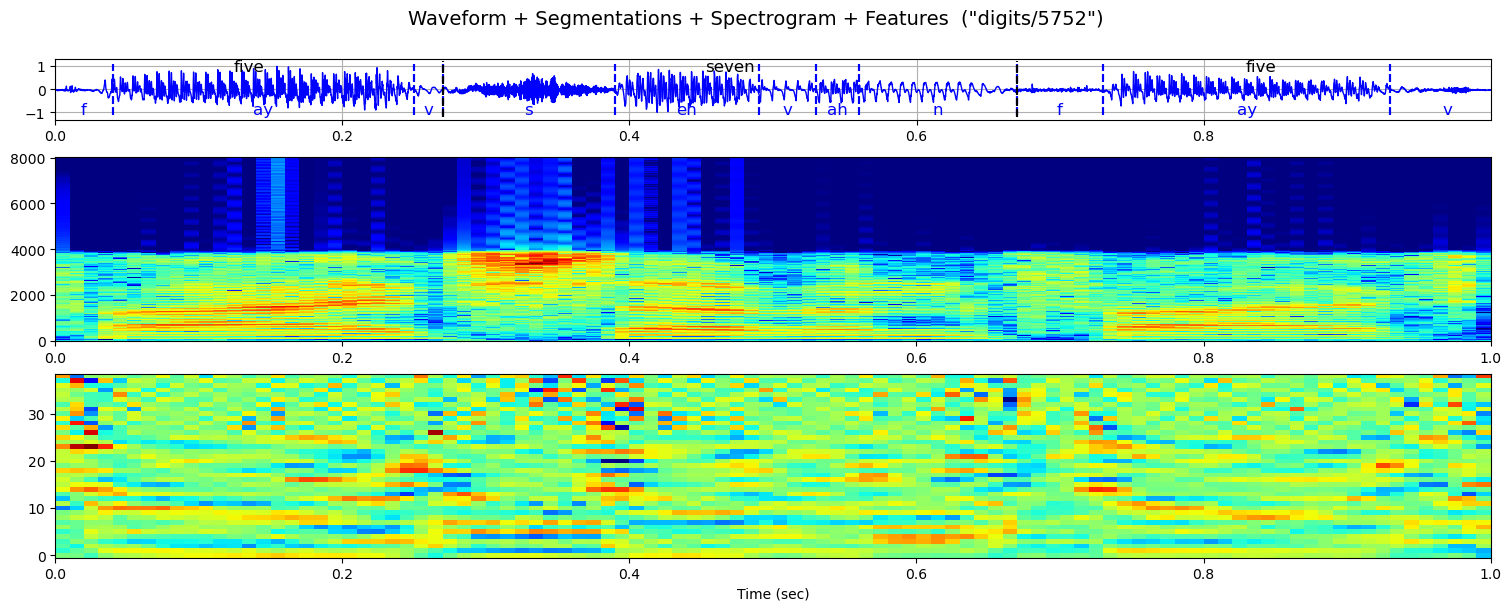

In [23]:
####################
#1. Model Selection
####################
if USE_DNN:
    acoustic_model = dnn_model
    nftrs = dnn_nftrs
else:
    acoustic_model = gmm_model
    nftrs = gmm_nftrs

####################
#2.a File Selection
####################
if file_id == 'demo/friendly':
    selection_times = np.array([0.48,1.04])
    canonical = ['sil','k',]       
elif file_id == 'misc/bad_bead_booed':
    selection_times = np.array([1.5,2.1])    
elif file_id == 'digits/5752':
    selection_times = np.array([0.,1.0])
elif file_id[:-1] == 'timit':
    no = int(file_id[5])
    timit_selection_times = [ [2.10,3.07], [.12,.82], [.05,.46], [1.96,2.7], [1.92,2.62] , [0.,1.], [0.,1.], [0.,1.] ] 
    selection_times = np.array(timit_selection_times[no])
else:
    print("Warning: file_id not recognized; default values used for selection highlighting")
    selection_times = np.array([0.2,0.8])

#######################################################
# 2.b Load file, transcripts and compute MFCC features
#######################################################
# load the full sentence data 
wavdata, sr, spgdata, ftrs, txt, seg_wrd, seg_phn = get_test_file(file_id,feature_args=feature_args)
delta_f = (sr/2)/(spgdata.shape[0]-1)
shift=feature_args['f_shift']
# only keep the required number of features from the default MFCC-39
ftrs=ftrs[:nftrs,:]
n_frames = ftrs.shape[1]
# transcript holds the sequence of phones in the reference transcription
# labels is the equivalent as a frame level sequence
transcript = seg_phn['seg'].tolist()
labels = pyspch.seg2lbls(seg_phn, n_frames=n_frames,pad_lbl='sil')

#####################################################################################
# 2.c Extract the "PROCESS" fragement from the utterance.  Use the same variable '+1' in the names
#####################################################################################

if USE_SELECTION:
    selection_times = selection_times
else:
    selection_times = np.array([0.,float(len(wavdata)-1)/float(sr)])

# time and frame references of PROCESS part wrt full utterance
frames= (selection_times* (1./shift) ).astype('int')
samples = (selection_times*sr).astype('int')
sample_slice = slice(samples[0],samples[1],1)
frame_slice = slice(frames[0],frames[1],1)
n_frames = frames[1]-frames[0]
times = selection_times

################
# wavdata1, ... are the PROCESS data rebased in time to start at t=0.
time_ax = np.arange(0,n_frames)*shift+0.5*shift
wavdata1 = wavdata[sample_slice]
spgdata1 = spgdata[:,frame_slice]
ftrs1 = ftrs[:,frame_slice]
#
seg_phn1 = seg_phn[(seg_phn['t0']<(frames[1]-1)*shift) & (seg_phn['t1']>(frames[0]+1)*shift)].reset_index(drop=True)
seg_phn1['t0'] = seg_phn1['t0']-selection_times[0]
seg_phn1['t1'] = seg_phn1['t1']-selection_times[0]
seg_phn1['t0'][0]= 0.0
seg_wrd1 = seg_wrd[(seg_wrd['t0']<(frames[1]-4)*shift) & (seg_wrd['t1']>(frames[0]+4)*shift)].reset_index(drop=True)
seg_wrd1['t0'] = seg_wrd1['t0']-selection_times[0]
seg_wrd1['t1'] = seg_wrd1['t1']-selection_times[0]
seg_wrd1['t0'][0]= 0.0
#
transcript1 = seg_phn1['seg'].tolist()
labels1 = pyspch.seg2lbls(seg_phn1, n_frames=ftrs1.shape[1],pad_lbl='sil')


#################################################################################################
# 4. SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata1, spgdata=spgdata1,dy=delta_f, #frames=frames,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs1])
fig.add_seg_plot(seg_phn1, iax=0, ypos=.1, color='b',size=12) 
fig.add_seg_plot(seg_wrd1, iax=0, ypos=.9, color='k',size=12)
fig.suptitle("Waveform + Segmentations + Spectrogram + Features  (\"%s\")\n" %(file_id),size=14)
display(fig)
display(Audio(data=wavdata,rate=sr))

### Frame Recognition

As a preliminary task we provide frame recognition.  This gives an idea of how well the utterance matches the given transcript for the model used.   
 
1. compute the class probabilities for each given feature vector
2. recognize by finding the maximum amongst all classes

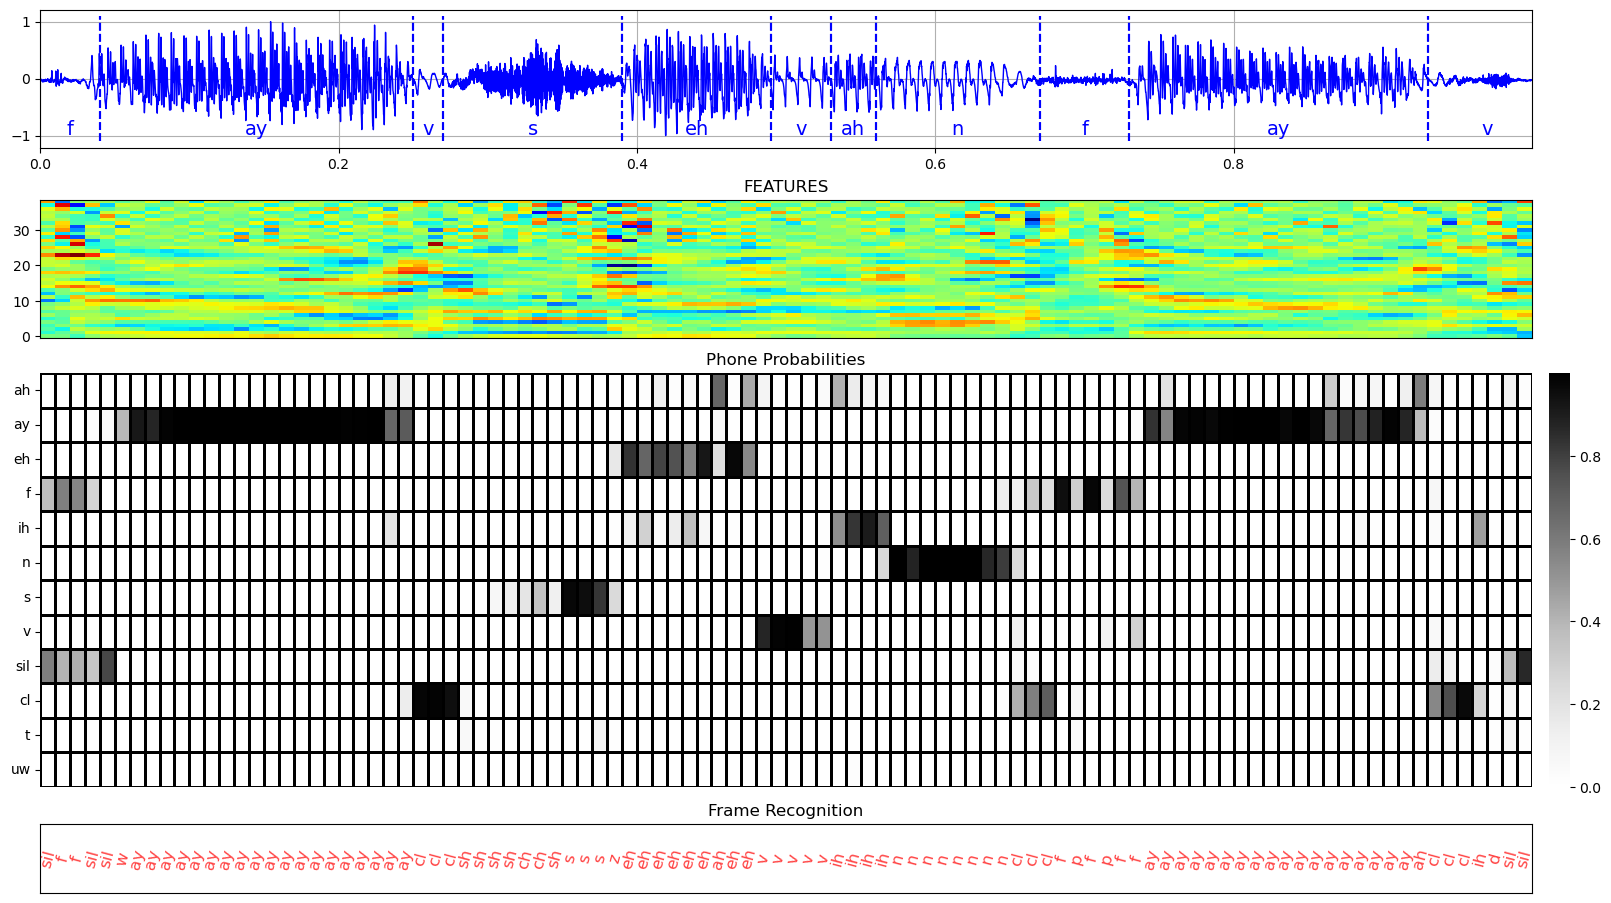

Frame Level Agreement with Reference after Frame Recognition(65/100): 65.00 %


In [24]:
# 1. Compute Frame Based Posteriors
frame_proba = acoustic_model.predict_proba(ftrs1.T)

# 2. Frame Recognition = Find the maximum amongst the classes
y_frame_idx = np.argmax(frame_proba, axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
y_frame_ldf = pd.DataFrame({'t':time_ax,'lbl':y_frame_lab})

# 3. Measure Recognition Rate
n_corr = np.sum([y_frame_lab[i] == labels1[i] for i in range(n_frames) ])

# 4. Illustrate: show the outputs of the most likely phones and at least all phones in the transcript, resorted for order in alphabet
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba,axis=0))[::-1][0:top_k]
indx_sel = np.sort(indx_sel)
phn_sel = [phn_set[i] for  i in indx_sel]
phn_sel,indx_sel = select_phones_idx((phn_sel,transcript),phn_set,SORTED=False)
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata1, spgdata=ftrs1,spglabel="",dy=1,row_heights=[1,1,3,.5],
            sample_rate=sr, figsize=(16,9),  img_ftrs=[None,None],img_labels=[None,None])

(iax_wav, iax_ftr, iax_prob, iax_frame) = (0,1,2,3)
fig.add_seg_plot(seg_phn1, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.axes[iax_ftr].set_title("FEATURES")
fig.axes[iax_ftr].set_xticks([])
plot_probs(frame_proba[:,indx_sel], phn_sel,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Phone Probabilities") 
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#F44',size=12,txtargs={'rotation':75},title="Frame Recognition")

fig.axes[iax_frame].set_xticks([])
fig.axes[iax_frame].set_xlabel("")
display(fig)

print("Frame Level Agreement with Reference after Frame Recognition(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames ) )

## 3. Viterbi Alignment
With a Viterbi Alignment we can align a given observation stream (feature vectors) against an HMM graph consisting of states (phones) and arcs (describing the possible transitions).
For the computations we use a TRELLIS, i.e. a matrix with time (observations) on the x-axis and HMM states on the y-axis.    
Each cell in a trellis contains the likelihood to be in a state 'S' at a given time 't' given the observation stream up to time 't.

When the exact transcription is known then the HMM graph takes the form of a strict left-to-right arrangement of HMM states . 

The graph may of course also be constructed to accept  multiple words / sentences / pronunciations ... correponding to any speech recognition problem.
A trellis is a good and efficient way to organize computations for small and moderate sized problems that we deal with here.  

### Computations
The computations involve following steps:   
1. compute the observation probabilities for each state given the feature vector (we compute the likelihoods indirectly from the probabilities used for frame recognition)
2. fill the trellis from left-to-right
3. Finalize: at the end of the observation stream you select the state with the highest likelihood to indicate the ending state.  However, you should only consider states that are ADMISSIBLE ending states (this is part of your graph definition)
4. Find the Viterbi alignment by backtracking on the trellis


### Use Cases

Different Use Cases have been predefined:   
CASE = "MANUAL"       use the manual transcript as reference   
CASE = "CANONICAL"    use the canonical transcript as reference   
CASE = "CANONICAL1"   same as CANONICAL but with   
CASE = "EX1", ..       a number of very specific use cases   

These can further be refined with additional flags   
- ADD_CL           will add a closure state before plosives  
- ADD_SIL_BETWEEN  will add a silence state between words   
- SKIP :           will allow skipping of states in the transcript    , or give a float number to specify the skip transition probs   
- ADD_SIL_END : will add a silence state at both ends of the transcript    


In [35]:
# Viterbi for a number of different use cases
#CASE = "MANUAL"
CASE="CANONICAL"
#CASE = "EX2"
SKIP = .5
ADD_CL = False
ADD_SIL_END = False
ADD_SIL_BETWEEN = True
extra_arcs = None

if CASE == "MANUAL":  # Strictly align against an available MANUAL transcription
    REF = "MANUAL"
elif CASE == "CANONICAL": # Loosely align against a canonical trancriptions allowing for skips 
    REF = "CANONICAL"
elif CASE == "CANONICAL1": # Loosely align against a canonical trancriptions allowing for skips 
    REF = "CANONICAL"
    SKIP = .1
elif CASE == "EX1": # recognize between COMPUTE, COMPUTER and COMPUTERS 
    REF = ["sil","k","ah","m", "p","y","uw","t","eh","r","s" ,"sil" ] 
    extra_arcs = [[7,11], [9,11] ]
    SKIP = 0.0
elif CASE == "EX2": # recognize between COMPUTE, COMPUTER and COMPUTERS 
    REF = ["sil","k","ah","m", "p","y","uw","t","er","s" ,"sil" ] 
    extra_arcs = [[7,10], [8,10] ]
    SKIP = 0.0
    
if SKIP is False: skip = 0.0
else: skip = SKIP
glue =  'sil' if ADD_SIL_BETWEEN else None
if REF == "MANUAL":  phone_seq = transcript1
elif REF == "CANONICAL": phone_seq = wrds_2_phns(seg_wrd1['seg'],lexicon=lexicon, glue=glue)
else: phone_seq = REF
# add closure state in front of every plosive
if ADD_CL and (REF!="MANUAL"):
    new_states = []
    for s in phone_seq:
        if s in ['p','t','k','b','d','g']: new_states.append('cl')
        new_states.append(s)
    phone_seq = new_states
# add silence at beginning and end
if ADD_SIL_END:
    phone_seq = ['sil'] + phone_seq + ['sil']
#print(phone_seq)    
obs_indx, trans_mat,init_mat,end_states = make_hmm(phone_seq,phn_set,l2r=1.0,skip=skip,extra_arcs=extra_arcs)
# Add labels of the type Si:S_label to distinguish clearly between state number in graph and acoustic phone model that this is referring to
# used in Hmm-graph viz and trellis 
state_labels = [ "S"+str(i)+":"+phone_seq[i] for i in range(len(phone_seq)) ]

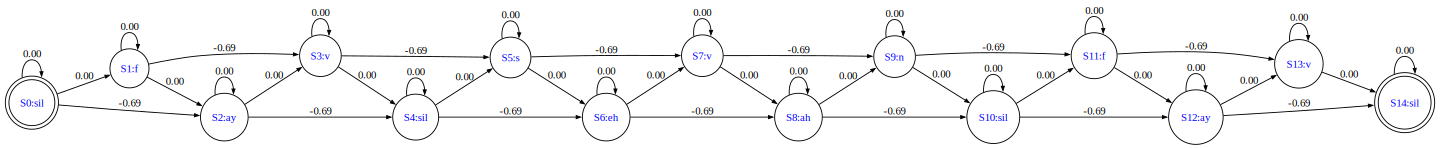

In [36]:
# HMMs work with "observation" likelihoods that can be computed (up to a scaling factor) from the posterior probabilities 
# For scaling/numerical purposes we do all computations with log-likelihoods / log-probabilities
# model class priors are used for correct conversion from posteriors to (scaled) likelihoods
frame_lik = proba_2_prob(frame_proba,priors=gmm_model.class_prior_)
log_lik = Spch.logf(frame_lik)
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=state_labels,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# we constructed the HMM graph with 'linear' probabilities, now we convert everything to log-probs
hmm1.set_probstyle('log')
# draw the graph here
g = hmm1.draw(PROBS=True,fmt="{:.2f}")
#for printing, rendering (pdf) or just viewing 
#print(g)
g.render()
display(g)

In [37]:
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(log_lik)
# recognize from the trellis
y_vit_trel = trellis1.backtrace()
#y_vit_lbl = hmm1.states[y_vit_trel]
y_vit_lbl = [ hmm1.states[k].split(":",1)[1] for k in trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':time_ax,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i+frames[0]] for i in range(len(y_vit_lbl))])
print("Frame level agreement with reference after Viterbi(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames) )

Frame level agreement with reference after Viterbi(91/100): 91.00 %


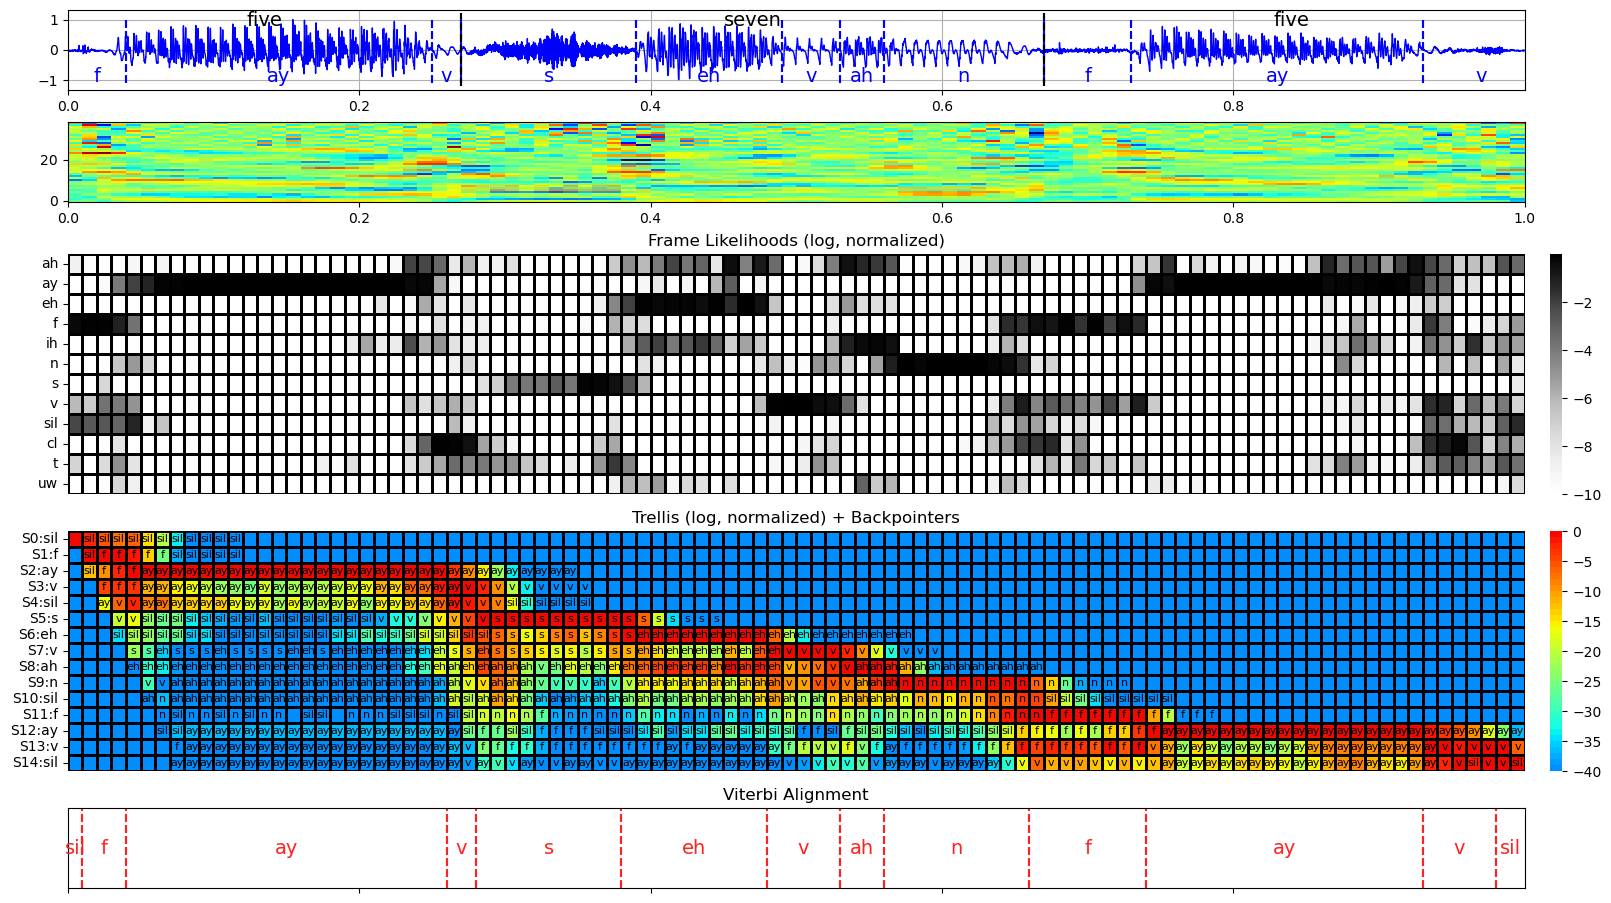

In [38]:
#
ANNOT =  "BACKPTRS" # must be BACKPTRS, VALUES or None
#ANNOT = "VALUES"
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata1, spgdata=ftrs1,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftrs, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn1, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.add_seg_plot(seg_wrd1, iax=iax_wav, ypos=.9, color='k',size=14)
#
plot_probs(log_lik[:,indx_sel],phn_sel,fig=fig, cmap='Greys',iax=iax_prob,title="Frame Likelihoods (log, normalized)",
          vmin=-10, style="img" ) # style="lin",yrange=[.,0]  )
#
trel_probs = trellis1.probs
bp_labels = make_bplabels(trellis1.backptrs,phone_seq)
if ANNOT is None:    kwargs = {}
elif ANNOT == "BACKPTRS": kwargs = { 'annot' : bp_labels.T, 'annot_kws':{'fontsize':8,'color':'k'}, 'fmt':'' }
elif ANNOT == "VALUES": kwargs = { 'annot' : True, 'fmt':'.0f' }
plot_probs(trellis1.probs,fig=fig,cmap=cmap_jet2,labels=state_labels,iax=iax_trel,title="Trellis (log, normalized) + Backpointers",
          style="img",vmin=-40,**kwargs) 
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#F22',size=14,title="Viterbi Alignment")
display(fig)

### PLOT a DETAILED VIEW of the last couple of columns

This view shows for the last couple of frames in the utterance and the last couple of phones in the transcript   
- observation probabilities   
- trellis probabilities   
- backpointers

Adjust VIEW_FRAMES and VIEW_PHONES for your example which is by default set to last 25 frames and last 8 phones

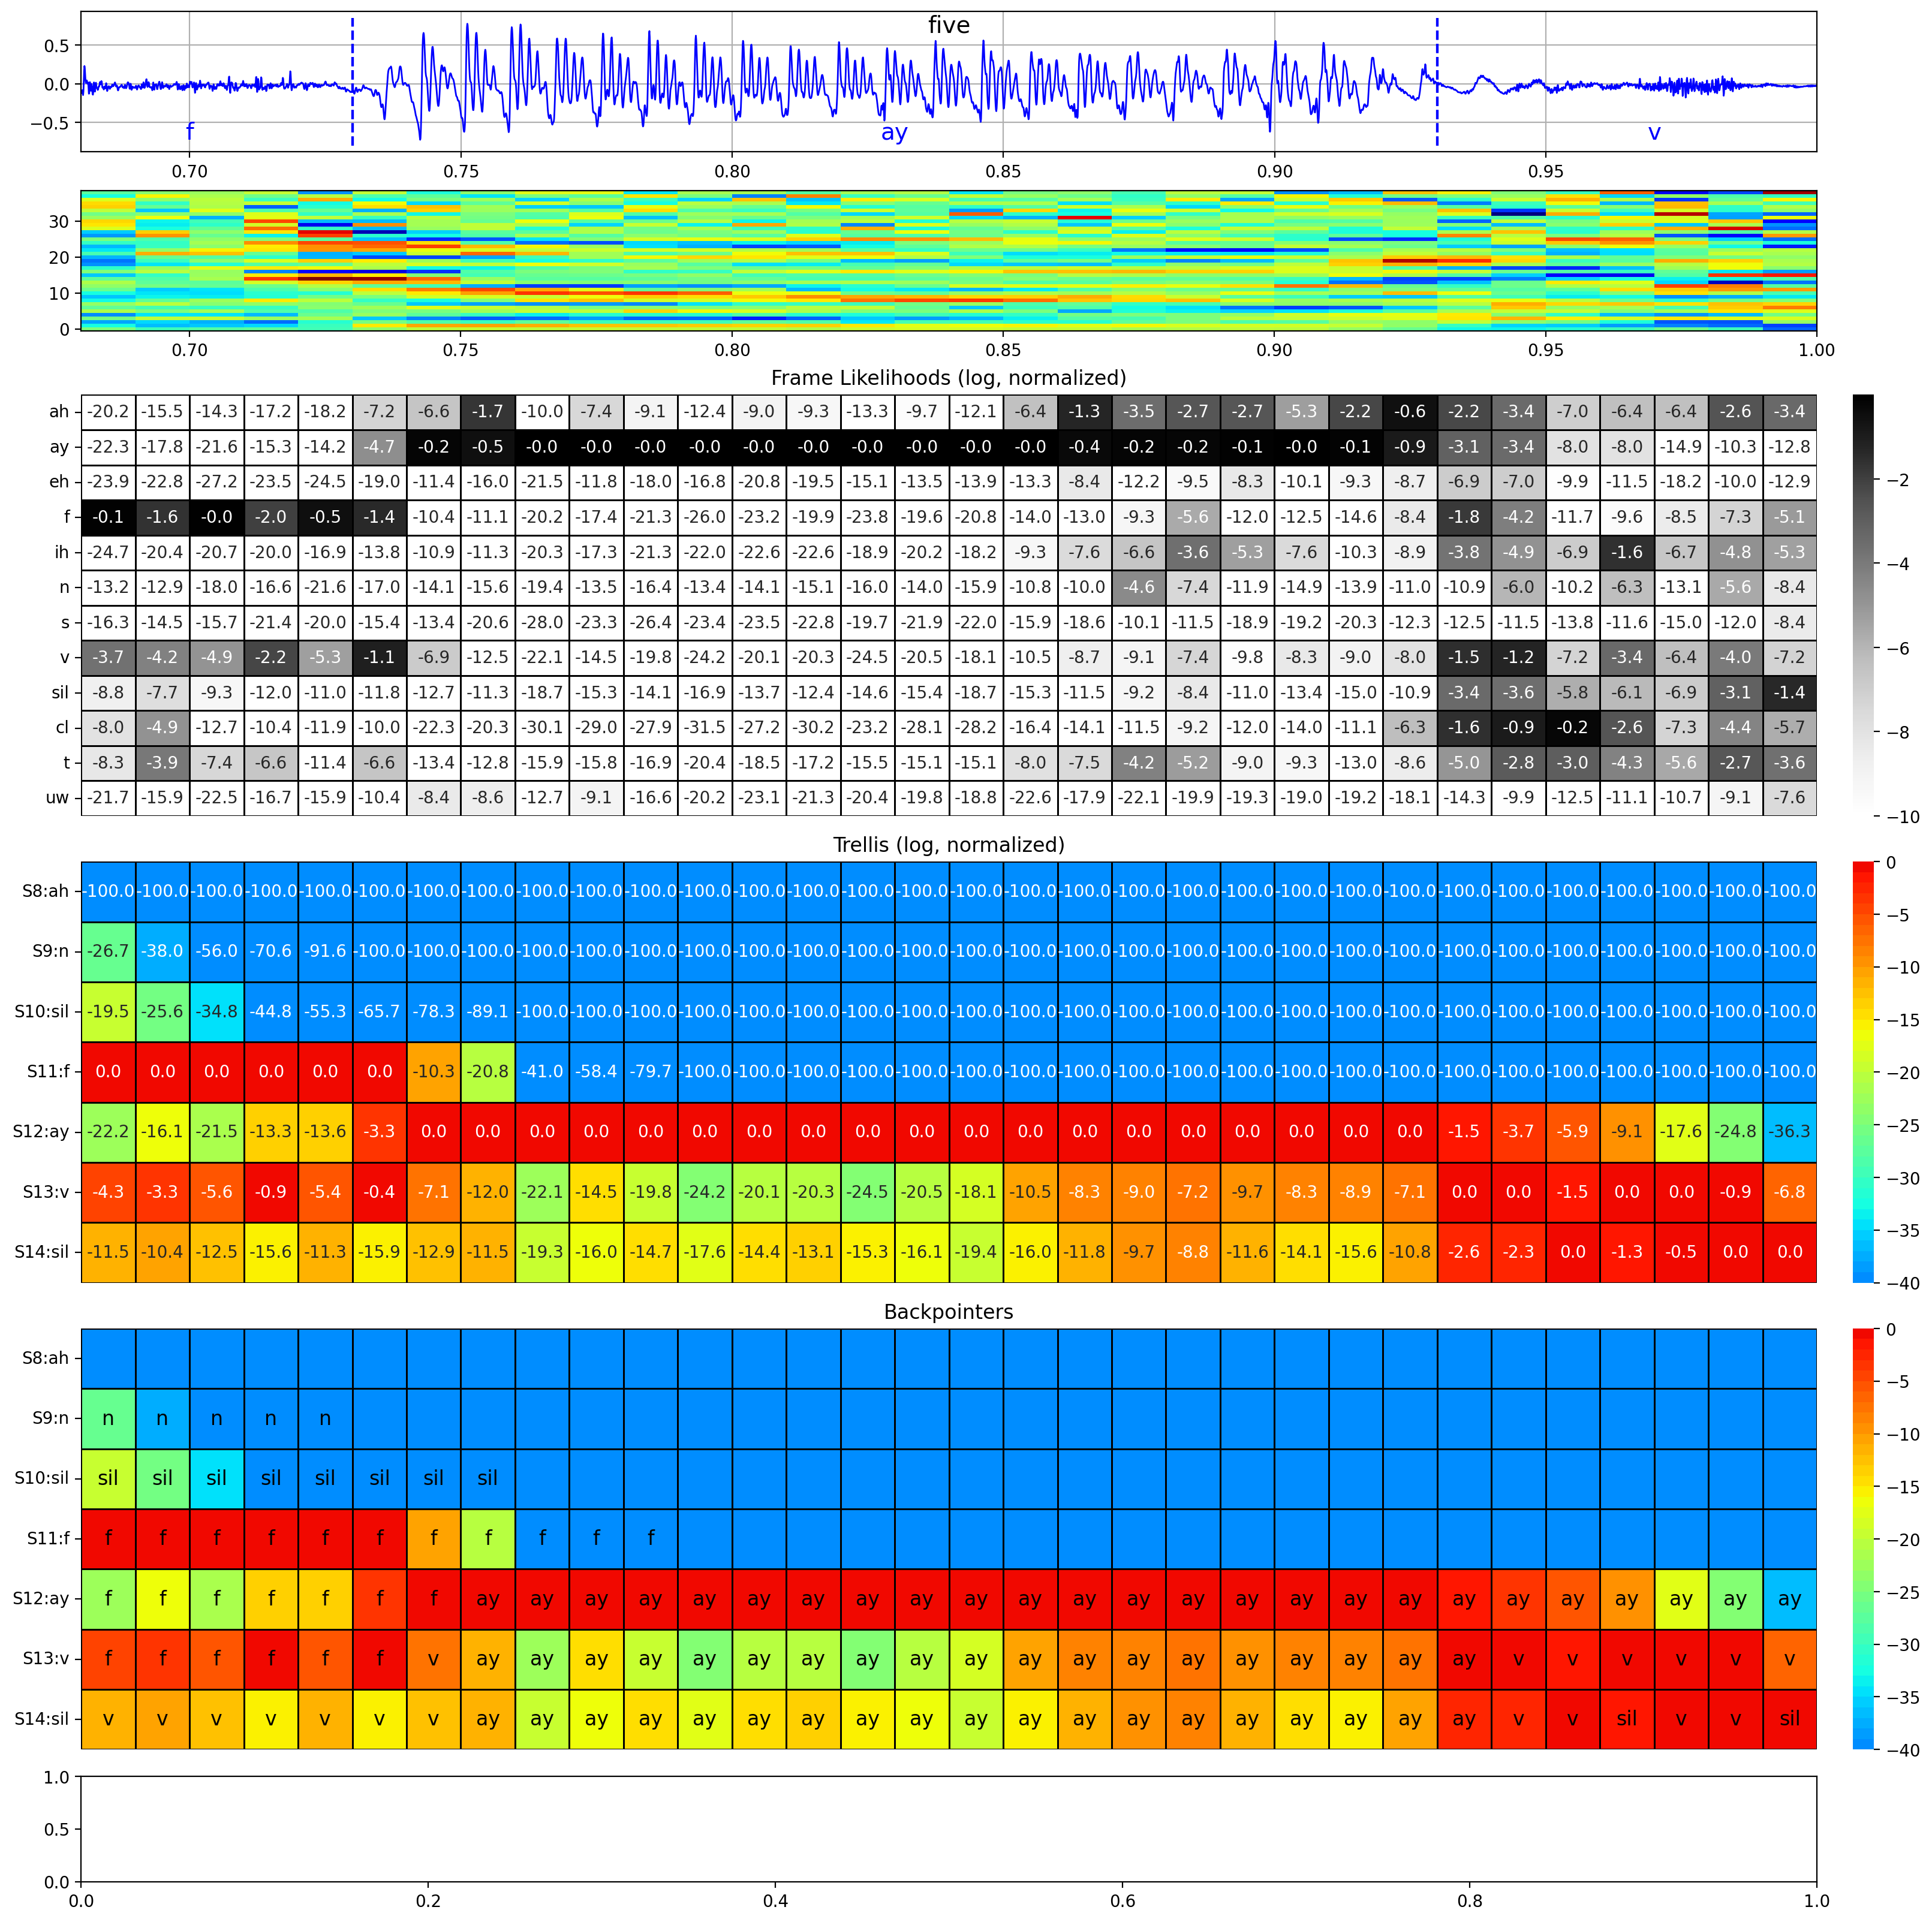

In [67]:
#
len_seq = len(phone_seq)
VIEW_FRAMES = slice(n_frames-32, n_frames,1)
VIEW_PHONES = slice(len_seq - 7, len_seq,1)
#VIEW_FRAMES = slice(0,40,1)
#VIEW_PHONES = slice(0,8,1)
#VIEW_FRAMES = slice(0,n_frames,1)
#VIEW_PHONES = slice(0,len_seq,1)
#
fig2 = pyspch.display.PlotSpgFtrs(wavdata=wavdata1, spgdata=ftrs1,spglabel="",dy=1,row_heights=[1,1,3,3,3,.75],
            frames=[VIEW_FRAMES.start, VIEW_FRAMES.stop],
            sample_rate=sr, figsize=(16,16), dpi=200, img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftrs, iax_prob,  iax_trel, iax_bptr, iax_vit ) = (0,1,2,3,4,5)
fig2.add_seg_plot(seg_phn1, iax=iax_wav, ypos=.1, color='b',size=14) 
fig2.add_seg_plot(seg_wrd1, iax=iax_wav, ypos=.9, color='k',size=14)
state_labels2 = [ state_labels[i] for i in range(VIEW_PHONES.start,VIEW_PHONES.stop) ]
phone_seq2 = [ phone_seq[i] for i in range(VIEW_PHONES.start,VIEW_PHONES.stop) ]
indx_sel2 = [ phn2idx[p] for p in phone_seq2 ]
#
# PLOT 1: Observation Probabilities
kwargs = { 'annot' : True, 'fmt':'.1f' , 'annot_kws':{'fontsize':10} }
plot_probs(log_lik[VIEW_FRAMES,indx_sel],phn_sel,fig=fig2, cmap='Greys',iax=iax_prob,title="Frame Likelihoods (log, normalized)",
          vmin=-10, style="img" ,**kwargs)

#plot_probs(log_lik[VIEW_FRAMES,indx_sel2],state_labels2,fig=fig2, cmap='Greys',iax=iax_prob,title="Frame Likelihoods (log, normalized)",
#          vmin=-10, style="img" , **kwargs) # style="lin",yrange=[.,0]  )
#
# PLOT 2: Trellis after Forward Pass
kwargs = { 'annot' : True, 'fmt':'.1f' , 'annot_kws':{'fontsize':10} }
plot_probs(trellis1.probs[VIEW_FRAMES,VIEW_PHONES],fig=fig2,cmap=cmap_jet2,labels=state_labels2,iax=iax_trel,title="Trellis (log, normalized)",
          style="img",vmin=-40,**kwargs)
#
# PLOT 3: Recognition via Backtracking
#bp_labels2 = make_bplabels(trellis1.backptrs,phone_seq,values=trellis1.probs,fmt='{:.1f}')
bp_labels2 = make_bplabels(trellis1.backptrs,phone_seq)
kwargs = { 'annot' : bp_labels2[VIEW_FRAMES,VIEW_PHONES].T, 'annot_kws':{'fontsize':12,'color':'k'}, 'fmt':'' }
plot_probs(trellis1.probs[VIEW_FRAMES,VIEW_PHONES],fig=fig2,cmap=cmap_jet2,labels=state_labels2,iax=iax_bptr,title="Backpointers",
          style="img",vmin=-40,**kwargs) 
#
# PLOT 4: Frame Recognition and Viterbi Alignment
#fig2.add_seg_plot(y_frame_ldf,iax=iax_vit,ypos=.75,color='k',size=12)
#fig2.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.25,color='#F22',size=14,title="Frame Recognition vs. Viterbi Alignment")
display(fig2)

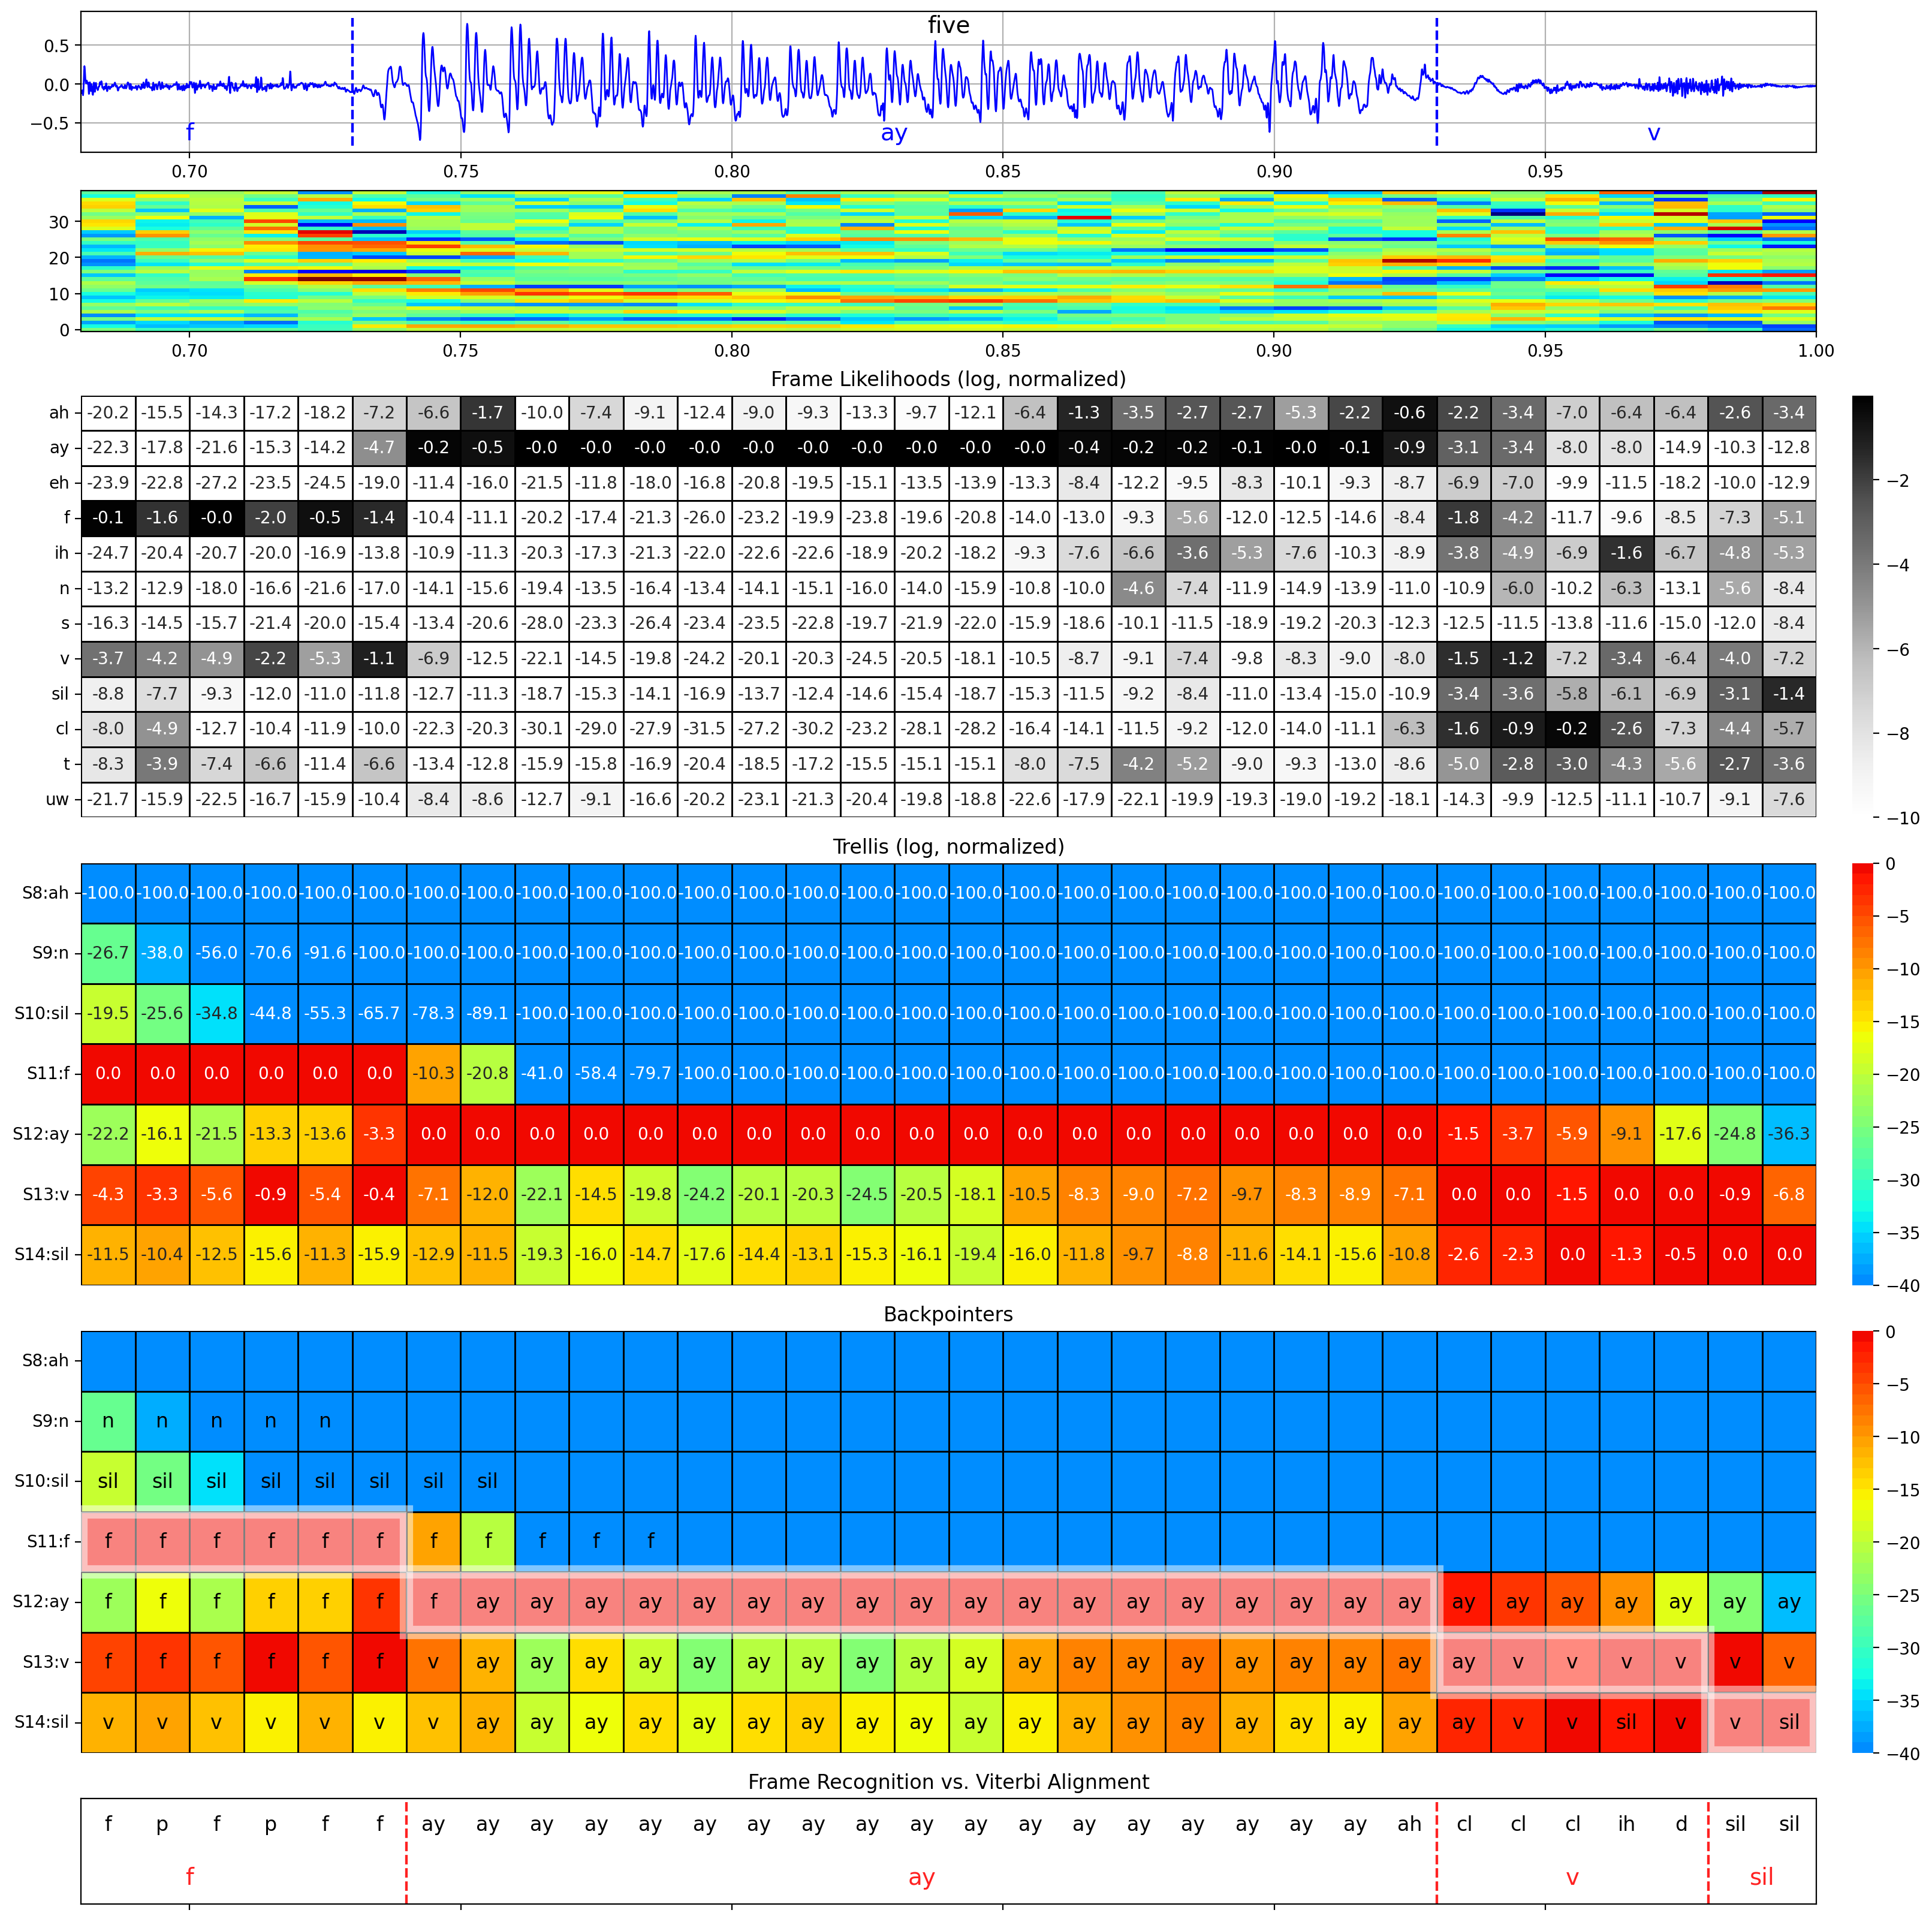

In [68]:
# PLOT 4: Frame Recognition and Viterbi Alignment
fig2.add_seg_plot(y_frame_ldf,iax=iax_vit,ypos=.75,color='k',size=12)
fig2.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.25,color='#F22',size=14,title="Frame Recognition vs. Viterbi Alignment")
ax_probs = fig2.axes[iax_bptr]
ifr_start = VIEW_FRAMES.start
for ifr in range(VIEW_FRAMES.start+1,VIEW_FRAMES.stop):
    if y_vit_trel[ifr] != y_vit_trel[ifr-1]:
        ax_probs.add_patch(Rectangle((ifr_start-VIEW_FRAMES.start,y_vit_trel[ifr-1]-VIEW_PHONES.start), ifr-ifr_start, 1, ec='white', fc='white', alpha=.5, lw=8)) 
        ifr_start = ifr        
ax_probs.add_patch(Rectangle((ifr_start-VIEW_FRAMES.start,y_vit_trel[ifr-1]-VIEW_PHONES.start), ifr+1-ifr_start, 1, ec='white', fc='white',alpha=.5, lw=8)) 
display(fig2)

In [ ]:
with :
    Spch.lbls2seg(y_vit_trel)

In [ ]:
pd.options.display.float_format

## ===============================

In [ ]:
i2 =  VIEW_FRAMES.stop
i1 = VIEW_FRAMES.start
trellis1.plot_trellis(i1=i1,i2=i2,vmin=-40,fmt=".1f",fontsize=8,figsize = (16,8),cmap=cmap_jet2,plot_backptrs=True,plot_alignment=True ) #plot_alignment=True,

In [ ]:
pd.set_option('display.float_format', '{:.1f}'.format)
nfr = log_probs.shape[0]
i1 = nfr-15
i2 = nfr
df_obs = pd.DataFrame(log_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
df_trel = pd.DataFrame(trel_probs[i1:frames[0]i2,:].T,index=phone_seq,columns=np.arange(i1,i2))
df_bptr = pd.DataFrame(bp_labels[i1:i2,:].T,index=phone_seq,columns=np.arange(i1,i2))
print("OBSERVATION PROBABILITIES (log)")
display(df_obs)
print("TRELLIS PROBABILITIES (log, normalized)")
display(df_trel)
print("BACKPOINTERS")
display(df_bptr)

## QUESTIONS

These questions relate to "EXERCISE2".   
Always assume that SILENCE at the end is optional as your end point detector used to generate the fragment may be cutting into the final parts of speech  

- What word did the system recognize at the end of the recording ?
- What word did you recognize if the recording was terminated at frame 44 ?
- Did you recognize SILENCE at the end in either of the above cases ?